# Day 15

## part 1

- if the robot moves into a box it will push it unless that means a box would hit a wall.
- GPS coordinate = $100l + c$ where $l$ is the line number and $c$ is the char number
- Find the sum of all the GPS coordinates of all boxes

In [9]:
from dataclasses import dataclass
import logging

from matplotlib import pyplot as plt
from tqdm import tqdm

from advent_of_code_utils.advent_of_code_utils import (
    parse_from_file, ParseConfig as PC, markdown, plot_grid, create_gif,
    embed_image, Point2 as P
)

log = logging.getLogger('day 15')
logging.basicConfig(level=logging.INFO)

In [10]:
directions = {
    '^': P(-1, 0),
    '>': P(0, 1),
    'v': P(1, 0),
    '<': P(0, -1),
    '\n': None
}

def parse_move(move: str) -> P:
    """convers puzzle input moves into vectors"""
    return directions[move]

parser = PC('\n\n', [
    PC('\n', PC('', str)),  # grid
    PC('', parse_move)  # moves
])

grid, moves = parse_from_file('day_15_example.txt', parser)
moves = [m for m in moves if m is not None]
log.info(f'loaded {len(moves)} moves')

INFO:advent_of_code_utils.py:2 items loaded from "day_15_example.txt"
INFO:day 15:loaded 15 moves


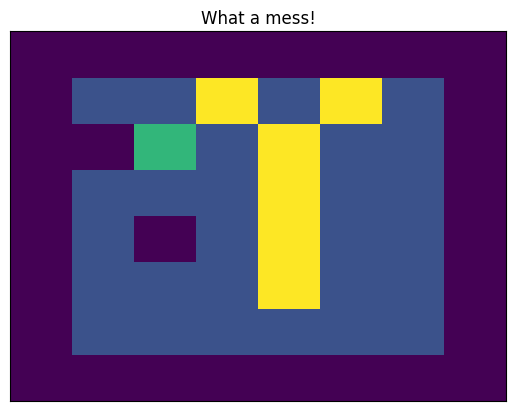

In [11]:
def plot_storage(grid: list[list[str]], ax: plt.Axes) -> None:
    """renders the grid state of the storage"""
    temp = [[ord(char) for char in line] for line in grid]
    plot_grid(temp, ax)

fig, ax = plt.subplots()
ax.set_title('What a mess!')
plot_storage(grid, ax)

I really want to make a gif out of this but there are 20k moves and the previous one was unhappy with 10k. Not to mention just caching all those states is going to be fairly hefty for solving the puzzle. So I think I'm going to have to compress what happens frame-frame to help with that.

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 41.95it/s]


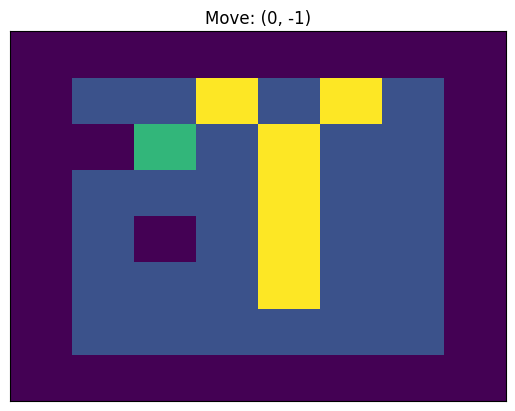

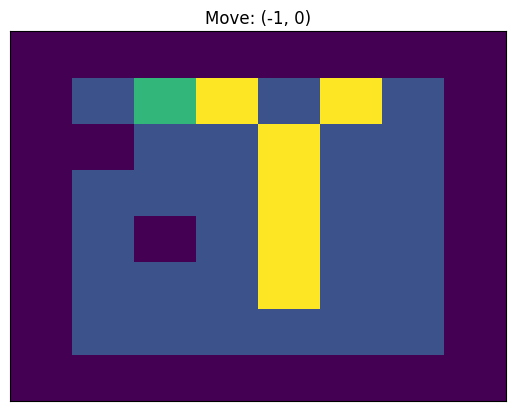

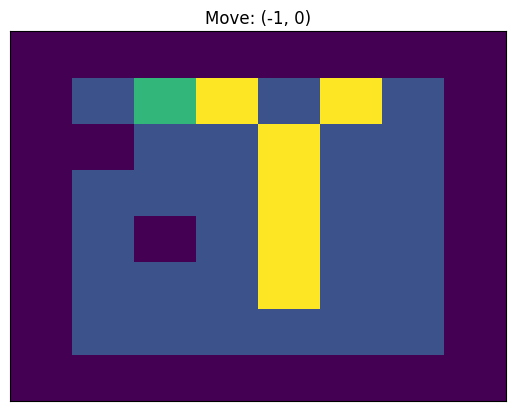

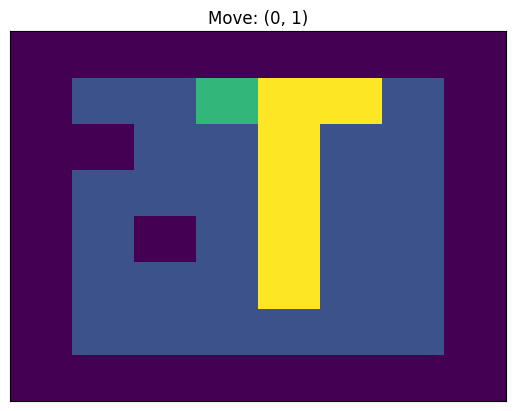

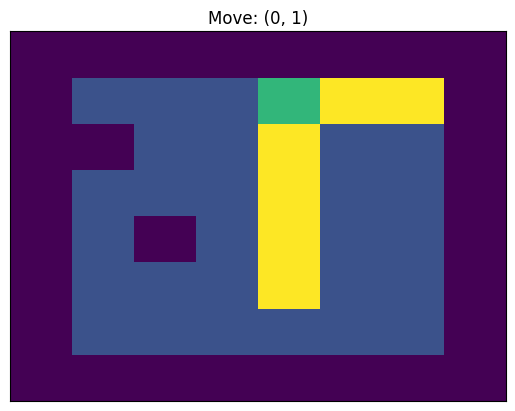

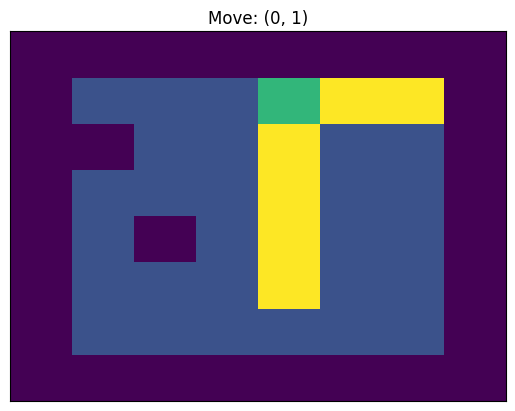

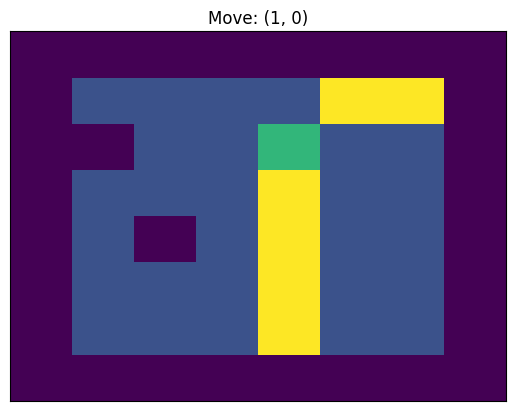

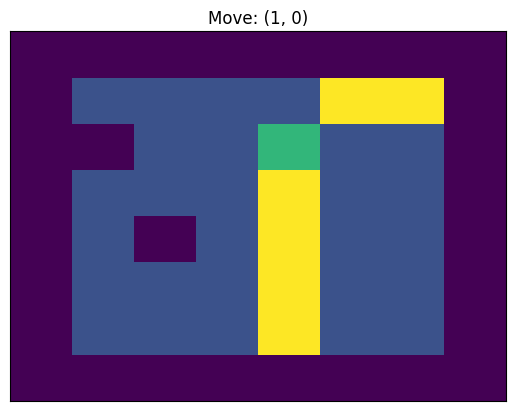

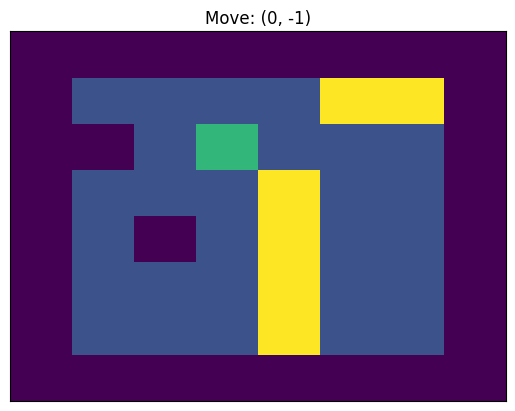

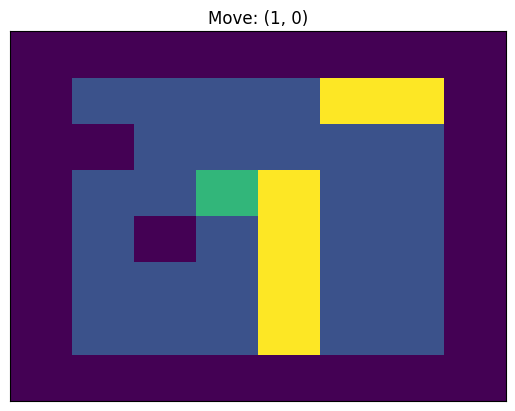

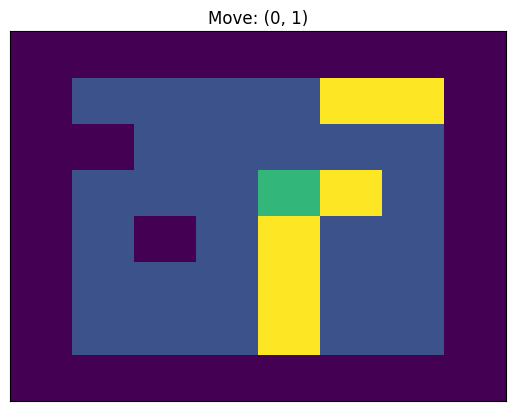

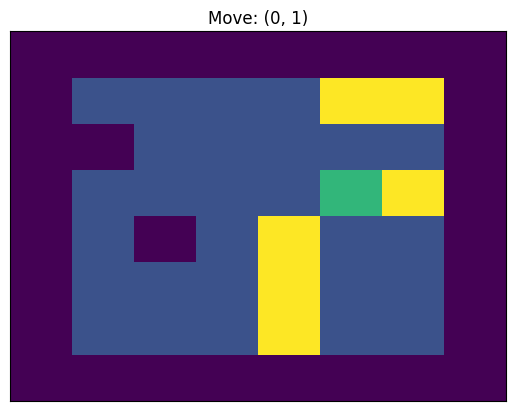

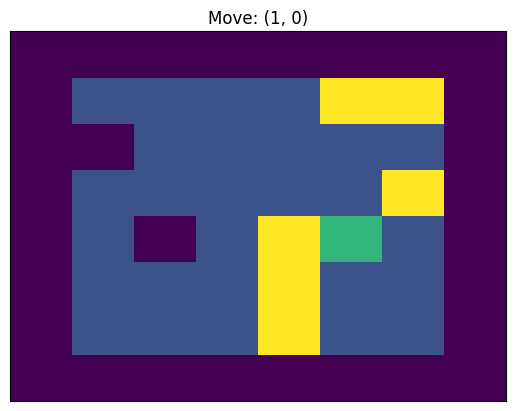

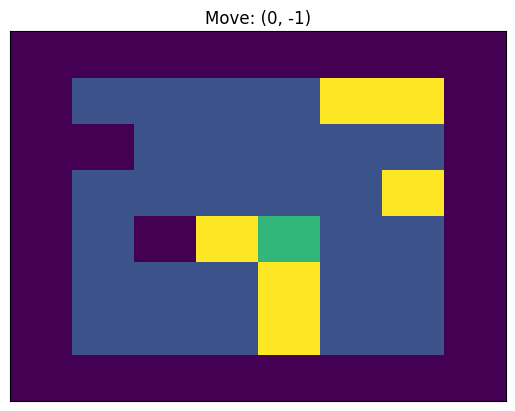

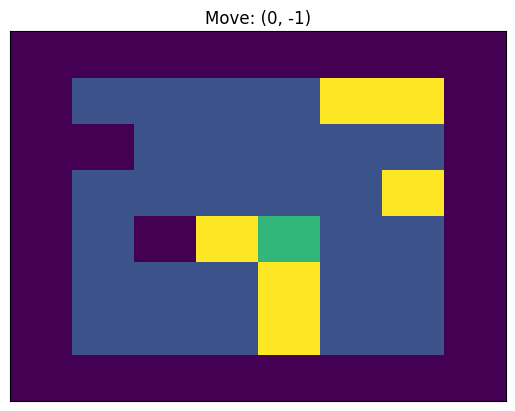

In [12]:
@dataclass
class Diff:
    """this will help store the difference at each step"""
    c: str
    f: P
    t: P

def move_robot(
    move: P, grid: list[list[str]], robot: P, create_plots: bool = False
) -> tuple[list[Diff], P]:
    """updates the grid with the new robot position"""  
    # try moving the robot
    current = P(robot.l, robot.c)
    next_tile = current + move
    updates = []
    # while in bounds, check going in that direction what lies in front
    while 0 <= next_tile.l < len(grid) and 0 <= next_tile.c < len(grid[0]):
        # if the next thing is a wall we can't move anymore
        if grid[next_tile.l][next_tile.c] in '#':
            updates = []  # clear updates so nothing gets updated
            break
        # otherwise add the update and increment the tile
        updates.append(Diff(grid[current.l][current.c], current, next_tile))
        # if the next tile is a space, break now that the update is appended
        if grid[next_tile.l][next_tile.c] in '.':
            break
        current = next_tile
        next_tile = current + move
    
    # then enact the updates in reverse

    for update in reversed(updates):
        grid[update.t.l][update.t.c] = update.c
        grid[update.f.l][update.f.c] = '.'
        if update.c == '@':
            robot += move

    log.debug(f'{updates=}')

    if create_plots:
        fig, ax = plt.subplots()
        ax.set_title(f'Move: {move}')
        plot_storage(grid, ax)

    return updates, robot

def find_robot(grid: list[list[str]]) -> P:
    """returns the coordinate of the robot"""
    for l, line in enumerate(grid):
        for c, char in enumerate(line):
            if char == '@':
                return P(l, c)
    else:
        raise ValueError(f'Can\'t find robot!')

updates = []
robot = find_robot(grid)
for move in tqdm(moves):
    temp, robot = move_robot(move, grid, robot, create_plots=True)
    updates.append(temp)

In [13]:
# ok that looks good let's run for real
grid, moves = parse_from_file('day_15.txt', parser)
moves = [m for m in moves if m is not None]
log.info(f'loaded {len(moves)} moves')
updates = []
robot = find_robot(grid)
for move in tqdm(moves):
    temp, robot = move_robot(move, grid, robot)
    updates.append(temp)

INFO:advent_of_code_utils.py:2 items loaded from "day_15.txt"
INFO:day 15:loaded 20000 moves
100%|██████████| 20000/20000 [00:00<00:00, 126617.82it/s]


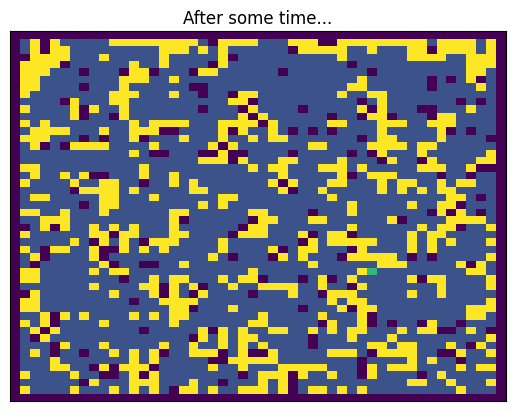

In [14]:
fig, ax = plt.subplots()
ax.set_title('After some time...')
plot_storage(grid, ax)

In [15]:
def get_total_gps(grid: list[list[str]]) -> int:
    """returns the total gps score for the store room"""
    total = 0
    for l, line in enumerate(grid):
        for c, char in enumerate(line):
            if char == 'O':
                total += (100 * l) + c
    return total

markdown(f'the total GPS after the moves is: {get_total_gps(grid)}')

the total GPS after the moves is: 1471826

But of course we want to see the little robot doing it's thing so let's try and create an animated version

I tried for some time to get a longer gif compiling but the way I'm trying to save it just doesn't like longer sets of images so I don't think having more than 1000 is a safe bet. So instead the whole thing in 20 parts!

In [16]:
grid, _ = parse_from_file('day_15.txt', parser)

def update_and_plot(update: list[Diff], ax: plt.Axes) -> None:
    """updates the current axis"""
    for diff in reversed(update):
        grid[diff.t.l][diff.t.c] = diff.c
        grid[diff.f.l][diff.f.c] = '.'
        
    plot_storage(grid, ax)

# this made the notebook too big for gitlab
# just look athe gif files directly instead
# block_length = 1000
# for block in range(20):
#     start = block_length * block
#     end = start + block_length
#     # on the last block include the last item too
#     if block == 19:
#         end += 1
#     gifpath = create_gif(
#         updates[start:end],
#         update_and_plot,
#         f'day_15_{block+1:02d}of20',
#         frame_duration_ms=40,
#         title=f'Let\'s see what\'s in store-room (part {block+1:02d}/20)',
#         append_iteration=True
#     )
#     embed_image(gifpath)

INFO:advent_of_code_utils.py:2 items loaded from "day_15.txt"


## part 2

- there is... another... robot
- but everything is double width
- GPS is now measured from the closest edge (so the `[` tile)

INFO:advent_of_code_utils.py:2 items loaded from "day_15.txt"
INFO:day 15:loaded 20000 moves
INFO:day 15:created double width grid with dimensions: 50x100
100%|██████████| 20000/20000 [00:00<00:00, 67811.01it/s]


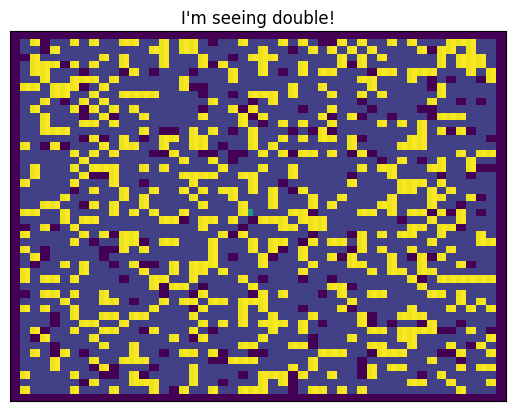

In [17]:
def double_grid(grid: list[list[str]]) -> list[list[str]]:
    """returns a double width grid"""
    temp = []
    convert = {
        '#': '##',
        'O': '[]',
        '.': '..',
        '@': '@.',
    }

    for line in grid:
        temp.append([])
        for char in line:
            temp[-1].extend([c for c in convert[char]])
    
    log.info(
        'created double width grid with dimensions: '
        f'{len(temp)}x{len(temp[0])}'
    )

    return temp

# next we need to update the move function
# moving left or right is the same as before
# but moving up or down requires a more involved check
def move_lr(move: P, grid: list[list[str]], robot: P) -> list[Diff]:
    """handles moving left or right"""
    current = P(robot.l, robot.c)
    next_tile = current + move
    updates = []
    # while in bounds, check going in that direction what lies in front
    while 0 <= next_tile.l < len(grid) and 0 <= next_tile.c < len(grid[0]):
        # if the next thing is a wall we can't move anymore
        if grid[next_tile.l][next_tile.c] in '#':
            updates = []  # clear updates so nothing gets updated
            break
        # otherwise add the update and increment the tile
        updates.append(Diff(grid[current.l][current.c], current, next_tile))
        # if the next tile is a space, break now that the update is appended
        if grid[next_tile.l][next_tile.c] in '.':
            break
        current = next_tile
        next_tile = current + move
    return updates

def move_ud(move: P, grid: list[list[str]], robot: P) -> list[Diff]:
    """handles moving up or down"""
    currents = [P(robot.l, robot.c)]
    updates = []

    while True:
        # iff all next tiles are '.' then we can stop checking
        if all(
            grid[tile.l][tile.c] == '.' for tile in currents
        ):
            return updates
        new_updates = []
        next_currents = []
        for current in currents:
            # check what's in this row - and added ones to check if
            # need be
            this_tile = grid[current.l][current.c]
            if this_tile == '#':
                return []
            elif this_tile == '[':
                to_update = [current, current + P(0, 1)]
            elif this_tile == ']':
                to_update = [current, current + P(0, -1)]
            elif this_tile == '.':
                to_update = []
            elif this_tile == '@':
                to_update = [current]
            else:
                raise ValueError(f'tile {this_tile} not recognised')

            # then add updates and capture which tiles still need checking next
            for tile in to_update:
                if tile in next_currents:
                    continue
                new_updates.append(
                    Diff(grid[tile.l][tile.c], tile, tile + move))
                next_currents.append(tile)
        # provided we didn't return add the new updates to the cache
        updates.extend(new_updates)
        currents = [tile + move for tile in next_currents]

def move_double_robot(
    move: P, grid: list[list[str]], robot: P, create_plots: bool = False
) -> tuple[list[Diff], P]:
    """updates the grid with the new robot position"""  
    # try moving the robot
    if move.c != 0:
        updates = move_lr(move, grid, robot)
    else:
        updates = move_ud(move, grid, robot)
    # then enact the updates in reverse

    for update in reversed(updates):
        grid[update.t.l][update.t.c] = update.c
        grid[update.f.l][update.f.c] = '.'
        if update.c == '@':
            robot += move

    log.debug(f'{updates=}')

    if create_plots:
        fig, ax = plt.subplots()
        ax.set_title(f'Move: {move}')
        plot_storage(grid, ax)

    return updates, robot

grid, moves = parse_from_file('day_15.txt', parser)
moves = [m for m in moves if m is not None]
log.info(f'loaded {len(moves)} moves')
grid = double_grid(grid)

fig, ax = plt.subplots()
ax.set_title('I\'m seeing double!')
plot_storage(grid, ax)

updates = []
robot = find_robot(grid)
for move in tqdm(moves):
    temp, robot = move_double_robot(move, grid, robot)
    updates.append(temp)

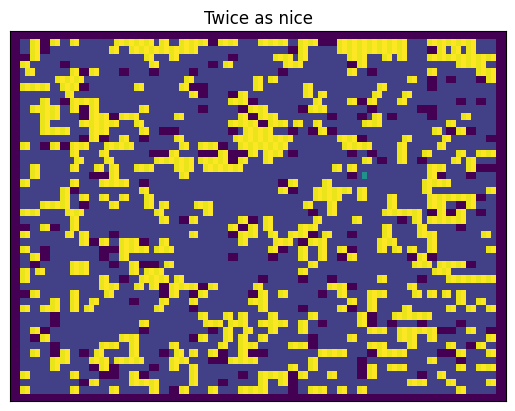

In [18]:
fig, ax = plt.subplots()
ax.set_title('Twice as nice')
plot_storage(grid, ax)

In [19]:
def get_double_gps(grid: list[list[str]]) -> int:
    """returns the total gps score for the store room"""
    total = 0
    for l, line in enumerate(grid):
        for c, char in enumerate(line):
            if char == '[':
                total += (100 * l) + c
    return total

markdown(f'the total GPS after the moves is: {get_double_gps(grid)}')

the total GPS after the moves is: 1457703

INFO:advent_of_code_utils.py:2 items loaded from "day_15.txt"


INFO:day 15:created double width grid with dimensions: 50x100
INFO:advent_of_code_utils.py:Creating 1000 frame images using "update_and_plot_double()"
generating frames: 100%|██████████| 1000/1000 [00:56<00:00, 17.55it/s]
INFO:advent_of_code_utils.py:1000 images saved to "img_temp"
INFO:advent_of_code_utils.py:Creating "day_15_part_2.gif" with frame duration 40ms, repeat=True
INFO:advent_of_code_utils.py:"day_15_part_2.gif" saved!
INFO:advent_of_code_utils.py:"img_temp" cleaned up
INFO:advent_of_code_utils.py:Embedding "day_15_part_2.gif"


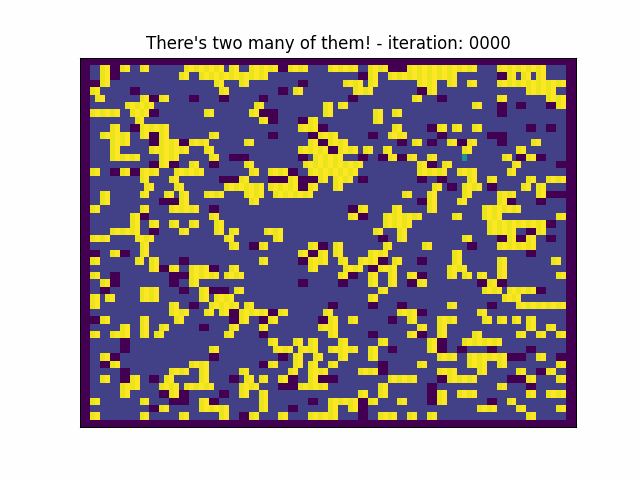

In [20]:
# let's have a look at the first and last bits of this one too
plotting_grid, _ = parse_from_file('day_15.txt', parser)
plotting_grid = double_grid(plotting_grid)

def update_and_plot_double(update: list[Diff], ax: plt.Axes) -> None:
    """updates the current axis"""
    for diff in reversed(update):
        plotting_grid[diff.t.l][diff.t.c] = diff.c
        plotting_grid[diff.f.l][diff.f.c] = '.'
        
    plot_storage(plotting_grid, ax)

for update in updates[:-1000]:
    for diff in reversed(update):
        plotting_grid[diff.t.l][diff.t.c] = diff.c
        plotting_grid[diff.f.l][diff.f.c] = '.'
gifpath = create_gif(
    updates[-1000:],
    update_and_plot_double,
    f'day_15_part_2',
    frame_duration_ms=40,
    title='There\'s two many of them!',
    append_iteration=True
)
embed_image(gifpath)